# Still Standing

Setting some variables that will be helpful later.

In [1]:
stillstanding_no = 51

In [2]:
date = '2023-02-21'

Importing libraries needed to run the rest of the notebook

In [3]:
import os
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import savgol_filter
%matplotlib inline

import os
import musicalgestures as mg
import maad
import librosa
import librosa.display

/home/alexander/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/alexander/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  meth

In [4]:
!ls ../1-raw/

2023-02-20_15-08-24_polar.CSV  2023-02-20-GS010126.LRV	2023-02-20-GS020126.LRV
2023-02-20_15-08-24_polar.TCX  2023-02-20-GS010126.THM	2023-02-20-GS020126.THM
2023-02-20-GS010126.360        2023-02-20-GS020126.360	2023-02-20T15.08.02.csv


In [5]:
fn_audio     = '../1-raw/2023-02-12-001.WAV'
fn_polar     = '../1-raw/2023-02-20_15-08-24_polar.CSV'
fn_IMU       = '../1-raw/2023-02-20T15.08.02.csv'

## Reading data from Polar Vantage V sports watch

In [6]:
data_polar = pd.read_csv(fn_polar, delimiter=',',index_col=0, low_memory=False, skiprows=2, usecols=[1,2,9])

In [7]:
data_polar

HR (bpm)  Temperatures (C)
Time                                
00:00:00        92              15.2
00:00:01        92              15.2
00:00:02        93              15.2
00:00:03        94              15.2
00:00:04        94              15.2
...            ...               ...
00:09:36        62              17.9
00:09:37        62              17.9
00:09:38        63              17.9
00:09:39        63              17.9
00:09:40        64              17.9

[581 rows x 2 columns]

Let us check the data types of the variables.

In [8]:
data_polar.dtypes

HR (bpm)              int64
Temperatures (C)    float64
dtype: object

And the data type of the index.

In [9]:
data_polar.index

Index(['00:00:00', '00:00:01', '00:00:02', '00:00:03', '00:00:04', '00:00:05',
       '00:00:06', '00:00:07', '00:00:08', '00:00:09',
       ...
       '00:09:31', '00:09:32', '00:09:33', '00:09:34', '00:09:35', '00:09:36',
       '00:09:37', '00:09:38', '00:09:39', '00:09:40'],
      dtype='object', name='Time', length=581)

This does not work, so we need to convert to a proper timecode:

In [10]:
data_polar.index = pd.TimedeltaIndex(data_polar.index)

### Pulse data

We calculate the median value to get the average pulse:

In [11]:
pulse = data_polar.iloc[:,0].median()
pulse

77.0

Plotting the pulse.

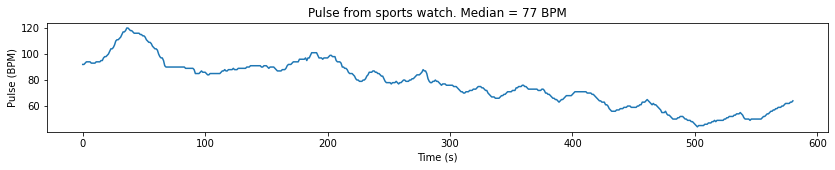

In [12]:
fig, ax = plt.subplots(figsize=(14,2))
plt.plot(data_polar.index.total_seconds(), data_polar.iloc[:,0]);

plt.ylabel('Pulse (BPM)')
plt.xlabel('Time (s)');
plt.title('Pulse from sports watch. Median = %i BPM' % pulse)

fig.savefig('%s_pulse.pdf' % date, bbox_inches='tight', facecolor='white')

### Temperature

Here we calculate the mean value of the temperature:

In [13]:
temperature = data_polar.iloc[:,1].median()
temperature

17.4

Then we look at the temperature:

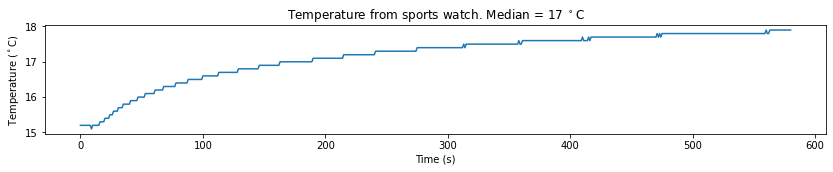

In [14]:
fig, ax = plt.subplots(figsize=(14,2))
plt.plot(data_polar.index.total_seconds(), data_polar.iloc[:,1]);

plt.ylabel('Temperature ($^\circ$C)')
plt.xlabel('Time (s)');
plt.title('Temperature from sports watch. Median = %i $^\circ$C' % temperature)

fig.savefig('%s_temperature.pdf' % date, bbox_inches='tight', facecolor='white')

## Read and check Data

Reading CSV files from [Physics Toolbox Sensor Suite](https://play.google.com/store/apps/dev?id=6483394247866966083&hl=en) by [Vieyra Software](https://www.vieyrasoftware.net/).

In [15]:
data = pd.read_csv(fn_IMU, delimiter=';',decimal=',',index_col=0, low_memory=False)

### Check files

Before moving on we should briefly check what we have imported.

In [16]:
data

gFx     gFy     gFz      ax      ay      az       wx      wy  \
time                                                                           
0.073110    −0,0048  0,4686  0,8891  0,0000  0,0000  0,0000   0,0000  0,0000   
0.081940    −0,0048  0,4686  0,8891  0,0000  0,0000  0,0000   0,0951  0,0191   
0.086572    −0,0048  0,4686  0,8891  0,0000  0,0000  0,0000   0,0951  0,0191   
0.126421    −0,0048  0,4686  0,8891  0,0000  0,0000  0,0000   0,0951  0,0191   
0.139554    −0,0305  0,4761  0,8826  0,0000  0,0000  0,0000   0,0951  0,0191   
...             ...     ...     ...     ...     ...     ...      ...     ...   
613.230976  −0,6954  0,0663  0,7072  0,1866  0,0126  0,2594  −0,0012  0,0382   
613.231714  −0,6954  0,0663  0,7072  0,1866  0,0126  0,2594  −0,0012  0,0382   
613.232430  −0,6954  0,0663  0,7072  0,2062  0,1251  0,1877  −0,0012  0,0382   
613.233115  −0,6954  0,0663  0,7072  0,2062  0,1251  0,1877  −0,0012  0,0382   
613.233671  −0,6928  0,0612  0,7179  0,2062  0,1251  0,1877  −0,0012  0,0382   

                 wz         p  ...        Bz      I  Azimuth    Pitch  \
time                           ...                                      
0.073110     0,0000    0.0000  ...    0,0000    0.0   0.0000   0,0000   
0.081940     0,0211    0.0000  ...    0,0000    0.0   0.0000   0,0000   
0.086572     0,0211    0.0000  ...  −53,6625    0.0   0.0000   0,0000   
0.126421     0,0211    0.0000  ...  −53,6625   53.0   0.0000   0,0000   
0.139554     0,0211    0.0000  ...  −53,6625   53.0   0.0000   0,0000   
...             ...       ...  ...       ...    ...      ...      ...   
613.230976  −0,0296  864.6514  ...  −33,3563  102.0  24.0872  −2,8057   
613.231714  −0,0296  864.6514  ...  −33,3563  102.0  23.9030  −3,0854   
613.232430  −0,0296  864.6514  ...  −33,3563  102.0  23.9030  −3,0854   
613.233115  −0,0296  864.6667  ...  −33,3563  102.0  23.9030  −3,0854   
613.233671  −0,0296  864.6667  ...  −33,3563  102.0  23.9030  −3,0854   

                Roll     Gain   Latitude Longitude  Speed (m/s)  Unnamed: 22  
time                                                                          
0.073110      0,0000       −∞   0.000000  0.000000          0.0          NaN  
0.081940      0,0000       −∞  60.506489  7.905864          0.0          NaN  
0.086572      0,0000       −∞  60.506489  7.905864          0.0          NaN  
0.126421      0,0000       −∞  60.506489  7.905864          0.0          NaN  
0.139554      0,0000       −∞  60.506489  7.905864          0.0          NaN  
...              ...      ...        ...       ...          ...          ...  
613.230976  −46,0763  69,1986  60.506504  7.905869          0.0          NaN  
613.231714  −46,1570  69,1986  60.506504  7.905869          0.0          NaN  
613.232430  −46,1570  69,1986  60.506504  7.905869          0.0          NaN  
613.233115  −46,1570  69,1986  60.506504  7.905869          0.0          NaN  
613.233671  −46,1570  69,1986  60.506504  7.905869          0.0          NaN  

[66100 rows x 22 columns]

This is a description of the variables:

| Name           | Description   | Unit |
|:----           |:-----------   |:---- |
| gFx            | g-force X     | FN/Fg |
| gFy            | g-force Y     | FN/Fg |
| gFz            | g-force Z     | FN/Fg |
| ax             | linear acceleration X | m/s2 |
| ay             | linear acceleration Y | m/s2 |
| az             | linear acceleration Z | m/s2 |
| wx             | gyroscope X   | rad/s |
| wy             | gyroscope Y   | rad/s |
| wz             | gyroscope Z   | rad/s |
| p              | barometer     | Pa |
| Bx             | magnetometer X | μT |
| By             | magnetometer Y | μT |
| Bz             | magnetometer Z | μT |
| I              | light meter   | lx |
| Azimuth        | inclinometer  | |
| Pitch          | inclinometer  | |
| Roll           | inclinometer  | |
| Gain           | sound meter   | dB |
| Latitude       | GPS Latitude  | degrees |
| Longitude      | GPS Longitude | degrees |
| Speed | m/s)   | GPS Speed     | km/h |

There is one column too much, due to a semicolon at the end of the file. Therefore, we remove the extra column like this:

In [17]:
data = data.drop(data.columns[21],axis=1)
data

gFx     gFy     gFz      ax      ay      az       wx      wy  \
time                                                                           
0.073110    −0,0048  0,4686  0,8891  0,0000  0,0000  0,0000   0,0000  0,0000   
0.081940    −0,0048  0,4686  0,8891  0,0000  0,0000  0,0000   0,0951  0,0191   
0.086572    −0,0048  0,4686  0,8891  0,0000  0,0000  0,0000   0,0951  0,0191   
0.126421    −0,0048  0,4686  0,8891  0,0000  0,0000  0,0000   0,0951  0,0191   
0.139554    −0,0305  0,4761  0,8826  0,0000  0,0000  0,0000   0,0951  0,0191   
...             ...     ...     ...     ...     ...     ...      ...     ...   
613.230976  −0,6954  0,0663  0,7072  0,1866  0,0126  0,2594  −0,0012  0,0382   
613.231714  −0,6954  0,0663  0,7072  0,1866  0,0126  0,2594  −0,0012  0,0382   
613.232430  −0,6954  0,0663  0,7072  0,2062  0,1251  0,1877  −0,0012  0,0382   
613.233115  −0,6954  0,0663  0,7072  0,2062  0,1251  0,1877  −0,0012  0,0382   
613.233671  −0,6928  0,0612  0,7179  0,2062  0,1251  0,1877  −0,0012  0,0382   

                 wz         p  ...        By        Bz      I  Azimuth  \
time                           ...                                       
0.073110     0,0000    0.0000  ...    0,0000    0,0000    0.0   0.0000   
0.081940     0,0211    0.0000  ...    0,0000    0,0000    0.0   0.0000   
0.086572     0,0211    0.0000  ...  −37,2375  −53,6625    0.0   0.0000   
0.126421     0,0211    0.0000  ...  −37,2375  −53,6625   53.0   0.0000   
0.139554     0,0211    0.0000  ...  −37,2375  −53,6625   53.0   0.0000   
...             ...       ...  ...       ...       ...    ...      ...   
613.230976  −0,0296  864.6514  ...   18,1500  −33,3563  102.0  24.0872   
613.231714  −0,0296  864.6514  ...   18,1500  −33,3563  102.0  23.9030   
613.232430  −0,0296  864.6514  ...   18,1500  −33,3563  102.0  23.9030   
613.233115  −0,0296  864.6667  ...   18,1500  −33,3563  102.0  23.9030   
613.233671  −0,0296  864.6667  ...   18,1500  −33,3563  102.0  23.9030   

              Pitch      Roll     Gain   Latitude  Longitude  Speed (m/s)  
time                                                                       
0.073110     0,0000    0,0000       −∞   0.000000   0.000000          0.0  
0.081940     0,0000    0,0000       −∞  60.506489   7.905864          0.0  
0.086572     0,0000    0,0000       −∞  60.506489   7.905864          0.0  
0.126421     0,0000    0,0000       −∞  60.506489   7.905864          0.0  
0.139554     0,0000    0,0000       −∞  60.506489   7.905864          0.0  
...             ...       ...      ...        ...        ...          ...  
613.230976  −2,8057  −46,0763  69,1986  60.506504   7.905869          0.0  
613.231714  −3,0854  −46,1570  69,1986  60.506504   7.905869          0.0  
613.232430  −3,0854  −46,1570  69,1986  60.506504   7.905869          0.0  
613.233115  −3,0854  −46,1570  69,1986  60.506504   7.905869          0.0  
613.233671  −3,0854  −46,1570  69,1986  60.506504   7.905869          0.0  

[66100 rows x 21 columns]

Let us just check what data types we have read in: 

In [18]:
data.dtypes

gFx             object
gFy             object
gFz             object
ax              object
ay              object
az              object
wx              object
wy              object
wz              object
p              float64
Bx              object
By              object
Bz              object
I              float64
Azimuth        float64
Pitch           object
Roll            object
Gain            object
Latitude       float64
Longitude      float64
Speed (m/s)    float64
dtype: object

There is obviously something wrong, since only one column has loaded with float values. By visual inspection we see that the minus signs are coded with a − (n-dash) instead of hyphen. This makes the importer fail, so that the decimal marker has not properly been changed from comma (,) to dot (.). So we need to change this. 

In [19]:
# Replacing n-dash with hyphen
data=data.replace(to_replace='−', value='-',regex=True)
# Replacing comma with dot
data=data.replace(to_replace=',', value='.',regex=True)
# Replacing NAN with zeros
data=data.replace(to_replace='∞', value='0',regex=True)
data

gFx     gFy     gFz      ax      ay      az       wx      wy  \
time                                                                           
0.073110    -0.0048  0.4686  0.8891  0.0000  0.0000  0.0000   0.0000  0.0000   
0.081940    -0.0048  0.4686  0.8891  0.0000  0.0000  0.0000   0.0951  0.0191   
0.086572    -0.0048  0.4686  0.8891  0.0000  0.0000  0.0000   0.0951  0.0191   
0.126421    -0.0048  0.4686  0.8891  0.0000  0.0000  0.0000   0.0951  0.0191   
0.139554    -0.0305  0.4761  0.8826  0.0000  0.0000  0.0000   0.0951  0.0191   
...             ...     ...     ...     ...     ...     ...      ...     ...   
613.230976  -0.6954  0.0663  0.7072  0.1866  0.0126  0.2594  -0.0012  0.0382   
613.231714  -0.6954  0.0663  0.7072  0.1866  0.0126  0.2594  -0.0012  0.0382   
613.232430  -0.6954  0.0663  0.7072  0.2062  0.1251  0.1877  -0.0012  0.0382   
613.233115  -0.6954  0.0663  0.7072  0.2062  0.1251  0.1877  -0.0012  0.0382   
613.233671  -0.6928  0.0612  0.7179  0.2062  0.1251  0.1877  -0.0012  0.0382   

                 wz         p  ...        By        Bz      I  Azimuth  \
time                           ...                                       
0.073110     0.0000    0.0000  ...    0.0000    0.0000    0.0   0.0000   
0.081940     0.0211    0.0000  ...    0.0000    0.0000    0.0   0.0000   
0.086572     0.0211    0.0000  ...  -37.2375  -53.6625    0.0   0.0000   
0.126421     0.0211    0.0000  ...  -37.2375  -53.6625   53.0   0.0000   
0.139554     0.0211    0.0000  ...  -37.2375  -53.6625   53.0   0.0000   
...             ...       ...  ...       ...       ...    ...      ...   
613.230976  -0.0296  864.6514  ...   18.1500  -33.3563  102.0  24.0872   
613.231714  -0.0296  864.6514  ...   18.1500  -33.3563  102.0  23.9030   
613.232430  -0.0296  864.6514  ...   18.1500  -33.3563  102.0  23.9030   
613.233115  -0.0296  864.6667  ...   18.1500  -33.3563  102.0  23.9030   
613.233671  -0.0296  864.6667  ...   18.1500  -33.3563  102.0  23.9030   

              Pitch      Roll     Gain   Latitude  Longitude  Speed (m/s)  
time                                                                       
0.073110     0.0000    0.0000       -0   0.000000   0.000000          0.0  
0.081940     0.0000    0.0000       -0  60.506489   7.905864          0.0  
0.086572     0.0000    0.0000       -0  60.506489   7.905864          0.0  
0.126421     0.0000    0.0000       -0  60.506489   7.905864          0.0  
0.139554     0.0000    0.0000       -0  60.506489   7.905864          0.0  
...             ...       ...      ...        ...        ...          ...  
613.230976  -2.8057  -46.0763  69.1986  60.506504   7.905869          0.0  
613.231714  -3.0854  -46.1570  69.1986  60.506504   7.905869          0.0  
613.232430  -3.0854  -46.1570  69.1986  60.506504   7.905869          0.0  
613.233115  -3.0854  -46.1570  69.1986  60.506504   7.905869          0.0  
613.233671  -3.0854  -46.1570  69.1986  60.506504   7.905869          0.0  

[66100 rows x 21 columns]

In [20]:
# Now that the data should have been formatted correctly, we can change to float64
data=data.astype(float)
data.dtypes

gFx            float64
gFy            float64
gFz            float64
ax             float64
ay             float64
az             float64
wx             float64
wy             float64
wz             float64
p              float64
Bx             float64
By             float64
Bz             float64
I              float64
Azimuth        float64
Pitch          float64
Roll           float64
Gain           float64
Latitude       float64
Longitude      float64
Speed (m/s)    float64
dtype: object

Then we should be ready to go. Let us just check the sampling rate first.

In [21]:
# The sampling rate is the total number of samples divided by time
sr = len(data)/data.index[-1]
sr

107.78925412267522

That is a quite high sampling rate, and probably higher than necessary. Let us therefore see if we can remove redundant rows (where there is no change of data). Since the acceleration data is most interesting for the future analysis, we use those columns for removing duplicates.

In [22]:
#data = data.drop_duplicates(subset=['gFx','gFy','gFz'], keep='first')
data = data.drop_duplicates(subset=['ax','ay','az'], keep='first')
data

gFx     gFy     gFz      ax      ay      az      wx      wy  \
time                                                                         
0.073110   -0.0048  0.4686  0.8891  0.0000  0.0000  0.0000  0.0000  0.0000   
0.216126   -0.0162  0.4722  0.8615 -0.1194  0.0068  0.0021  0.0701  0.0214   
0.282885   -0.0261  0.4729  0.8858 -0.0288  0.0028 -0.1117 -0.0409 -0.1147   
0.351478   -0.0121  0.4829  0.8953 -0.0972  0.0197  0.0521 -0.0267 -0.0408   
0.416772    0.0257  0.4696  0.8181  0.0284  0.0688  0.1400  0.0235  0.0246   
...            ...     ...     ...     ...     ...     ...     ...     ...   
612.964825 -0.7358  0.0369  0.6229  0.1092 -0.0805 -0.3158  0.0907 -0.6865   
613.030955 -0.6895  0.0378  0.6820  0.4173 -0.0564  0.1391  0.0107 -0.2343   
613.099208 -0.7165  0.0624  0.7172  0.0584  0.1633  0.3472  0.0121 -0.2057   
613.165419 -0.6967  0.0500  0.7158  0.1866  0.0126  0.2594  0.0664 -0.1031   
613.232430 -0.6954  0.0663  0.7072  0.2062  0.1251  0.1877 -0.0012  0.0382   

                wz         p  ...       By       Bz      I   Azimuth    Pitch  \
time                          ...                                               
0.073110    0.0000    0.0000  ...   0.0000   0.0000    0.0    0.0000   0.0000   
0.216126    0.0185  864.7869  ... -38.0250 -53.4563   53.0    0.0000   0.0000   
0.282885   -0.0278  864.7866  ... -38.0625 -53.4750   53.0  339.1671 -28.2938   
0.351478    0.0040  864.7876  ... -37.9500 -53.4750   53.0  339.7584 -28.1782   
0.416772    0.0759  864.7717  ... -37.9313 -53.5313   53.0  339.7584 -28.1782   
...            ...       ...  ...      ...      ...    ...       ...      ...   
612.964825  0.0023  864.6077  ...  19.9875 -20.5688  115.0   24.8112  -2.3982   
613.030955 -0.0069  864.6099  ...  19.5750 -23.8875  115.0   25.3962  -2.6022   
613.099208 -0.0287  864.6262  ...  19.2375 -27.1313  102.0   24.8922  -2.5198   
613.165419  0.0049  864.6338  ...  18.8813 -29.9813  102.0   24.0872  -2.8057   
613.232430 -0.0296  864.6514  ...  18.1500 -33.3563  102.0   23.9030  -3.0854   

               Roll     Gain   Latitude  Longitude  Speed (m/s)  
time                                                             
0.073110     0.0000  -0.0000   0.000000   0.000000          0.0  
0.216126     0.0000  -0.0000  60.506489   7.905864          0.0  
0.282885    -1.1420  -0.0000  60.506489   7.905864          0.0  
0.351478    -0.9783  -0.0000  60.506489   7.905864          0.0  
0.416772    -0.9783  -0.0000  60.506489   7.905864          0.0  
...             ...      ...        ...        ...          ...  
612.964825 -50.7607  69.1986  60.506504   7.905869          0.0  
613.030955 -48.7454  69.1986  60.506504   7.905869          0.0  
613.099208 -47.6291  69.1986  60.506504   7.905869          0.0  
613.165419 -46.0763  69.1986  60.506504   7.905869          0.0  
613.232430 -46.1570  69.1986  60.506504   7.905869          0.0  

[9183 rows x 21 columns]

That helped in removing quite a lot of data. Let us check the new sampling rate.

In [23]:
# The sampling rate is the total number of samples divided by time
sr = len(data)/data.index[-1]
sr

14.974746198598792

That is a much more senseable sampling rate, and will also save storage and processing.

## Getting an overview of the data

A basic plot of all the data will give us an idea about the temporal development.

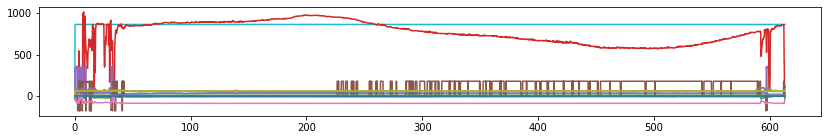

In [24]:
fig = plt.figure(figsize=(14,2))
plt.plot(data);

It is difficult to see exactly what is happening at the beginning and end. Since the accelerometer data may be what we are most interested in, let us only plot that data stream.

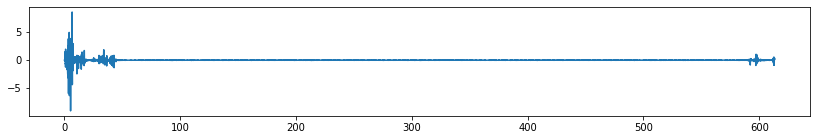

In [25]:
fig = plt.figure(figsize=(14,2))
plt.plot(data.ax);

We can see that there is a lot of movement in the beginning and end. This is when I moved the mobile phone before and after the experiment. So I want to remove those parts. 

In [29]:
# Cutting off the first 50 seconds of the file
data_without_beginning = data.tail(-60*int(sr))

In [30]:
# Cutting off the last 20 seconds of the file
data_clean = data_without_beginning.head(-40*int(sr))

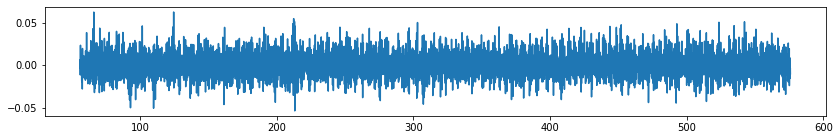

In [31]:
fig = plt.figure(figsize=(14,2))
plt.plot(data_clean.ax);

In [32]:
time_array = data_clean.index[1:]
duration = time_array[-1]-time_array[1]
duration

519.471278

In [33]:
data_clean

gFx     gFy     gFz      ax      ay      az      wx      wy  \
time                                                                         
56.235025  -0.9934 -0.0297  0.0298  0.0062  0.0141 -0.0569  0.0090 -0.0049   
56.301331  -0.9952 -0.0288  0.0416 -0.0116  0.0337 -0.0180 -0.0002 -0.0234   
56.369369  -0.9948 -0.0313  0.0342 -0.0028  0.0193 -0.0605  0.0082  0.0076   
56.434062  -0.9939 -0.0247  0.0275  0.0234  0.0671 -0.0755 -0.0084 -0.0283   
56.502529  -0.9922 -0.0308  0.0399 -0.0037 -0.0131 -0.0134 -0.0084 -0.0283   
...            ...     ...     ...     ...     ...     ...     ...     ...   
575.573397 -0.9930 -0.0232 -0.0155 -0.0031  0.0216 -0.0301  0.0177  0.0026   
575.639649 -0.9961 -0.0338 -0.0060  0.0044  0.0057 -0.0380 -0.0209  0.0061   
575.709533 -0.9961 -0.0282 -0.0203 -0.0054  0.0192 -0.0446  0.0070  0.0211   
575.774501 -0.9965 -0.0275 -0.0085 -0.0036  0.0167  0.0330 -0.0012 -0.0043   
575.840647 -0.9959 -0.0296 -0.0092 -0.0102  0.0125 -0.0109  0.0005 -0.0043   

                wz         p  ...       By       Bz      I  Azimuth     Pitch  \
time                          ...                                               
56.235025  -0.0035  864.8511  ...  27.8438 -11.2688  849.0  23.7029    1.8472   
56.301331  -0.0066  864.8528  ...  27.7875 -11.0438  849.0  23.7029    1.8472   
56.369369   0.0005  864.8484  ...  27.7875 -10.8750  850.0  23.7072    1.8475   
56.434062  -0.0107  864.8508  ...  27.7688 -10.5375  850.0  23.7984    1.8453   
56.502529  -0.0107  864.8516  ...  27.6375 -10.4250  851.0  23.8755    1.8486   
...            ...       ...  ...      ...      ...    ...      ...       ...   
575.573397  0.0067  864.8005  ...  27.7125  -8.1375  733.0  34.2483  178.2498   
575.639649 -0.0124  864.7927  ...  27.7500  -8.0063  733.0  34.3797  178.2895   
575.709533 -0.0015  864.7827  ...  27.6750  -8.0438  734.0  34.3302  178.2466   
575.774501 -0.0008  864.7808  ...  27.6750  -8.0625  734.0  34.5053  178.2578   
575.840647 -0.0021  864.7786  ...  27.7500  -7.9688  734.0  34.4866  178.2681   

               Roll     Gain   Latitude  Longitude  Speed (m/s)  
time                                                             
56.235025  -87.7557  49.7259  60.506504   7.905869          0.0  
56.301331  -87.7557  50.6029  60.506504   7.905869          0.0  
56.369369  -87.6853  50.6029  60.506504   7.905869          0.0  
56.434062  -87.6784  50.6029  60.506504   7.905869          0.0  
56.502529  -87.7014  50.6029  60.506504   7.905869          0.0  
...             ...      ...        ...        ...          ...  
575.573397 -89.5266  53.9207  60.506504   7.905869          0.0  
575.639649 -89.4761  53.9207  60.506504   7.905869          0.0  
575.709533 -89.4660  56.9804  60.506504   7.905869          0.0  
575.774501 -89.3625  56.9804  60.506504   7.905869          0.0  
575.840647 -89.3683  56.9804  60.506504   7.905869          0.0  

[7783 rows x 21 columns]

Now we finally have a dataset that we can investigate further. Before moving on, let us save it as a clean CSV file. 

In [34]:
data_clean.to_csv('%s_data_clean.csv' % date)

## Sound and light levels

In [35]:
light_level = data_clean.I.median()
light_level

756.0

<Figure size 1008x144 with 0 Axes>

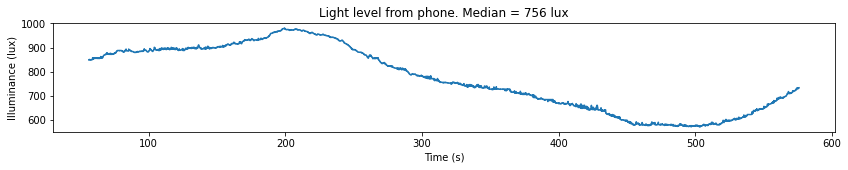

In [36]:
fig = plt.figure(figsize=(14,2))

fig, ax = plt.subplots(figsize=(14,2))
plt.plot(data_clean.index, data_clean.I);

plt.ylabel('Illuminance (lux)')
plt.xlabel('Time (s)');
plt.title('Light level from phone. Median = %i lux' % light_level)

fig.savefig('%s_illuminance.pdf' % date, bbox_inches='tight', facecolor='white')

In [37]:
sound_level = data_clean.Gain.median()
sound_level

52.3811

<Figure size 1008x144 with 0 Axes>

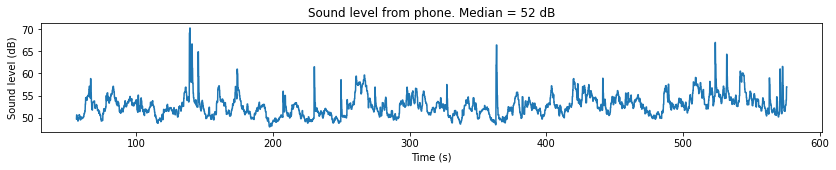

In [38]:
fig = plt.figure(figsize=(14,2))

fig, ax = plt.subplots(figsize=(14,2))
plt.plot(data_clean.index, data_clean.Gain);

plt.ylabel('Sound level (dB)')
plt.xlabel('Time (s)');
plt.title('Sound level from phone. Median = %i dB' % sound_level)

fig.savefig('%s_sound_level.pdf' % date, bbox_inches='tight', facecolor='white')

## Descriptive statistics

Then we can look at some basic descriptive statistics.

In [39]:
data_stats = data.describe(include='all')
data_stats

gFx          gFy          gFz           ax           ay  \
count  9183.000000  9183.000000  9183.000000  9183.000000  9183.000000   
mean     -0.985430    -0.029251     0.000824     0.001228     0.018604   
std       0.083071     0.049862     0.110246     0.278246     0.169782   
min      -1.607200    -0.775900    -1.364800    -9.001600    -3.229400   
25%      -0.996000    -0.034000    -0.009000    -0.009300     0.007000   
50%      -0.995200    -0.032000    -0.000700    -0.001400     0.018400   
75%      -0.994200    -0.029900     0.012300     0.006700     0.030100   
max       0.468900     0.714200     0.895300     8.556400     2.487100   

                az           wx           wy           wz            p  ...  \
count  9183.000000  9183.000000  9183.000000  9183.000000  9183.000000  ...   
mean     -0.021786     0.000203    -0.002596    -0.004311   864.688432  ...   
std       0.289712     0.136601     0.446595     0.134265     9.024775  ...   
min      -5.831500    -2.749000   -12.566600    -3.000600     0.000000  ...   
25%      -0.047700    -0.004400    -0.013300    -0.005700   864.720800  ...   
50%      -0.020000     0.000900    -0.004300    -0.003400   864.786600  ...   
75%       0.005300     0.006400     0.004600    -0.001200   864.854350  ...   
max      11.228500     2.537500    15.999300     3.005100   865.188700  ...   

                By           Bz            I      Azimuth        Pitch  \
count  9183.000000  9183.000000  9183.000000  9183.000000  9183.000000   
mean     27.312912    -8.661054   760.366656    37.235976    83.903506   
std       4.332757     6.344511   156.439366    31.190798    91.440624   
min     -40.087500   -61.537500     0.000000     0.000000  -179.824400   
25%      27.618800    -9.009400   653.000000    33.389650     2.017750   
50%      27.768800    -8.418800   770.000000    34.446300     2.234200   
75%      27.918800    -8.043800   888.000000    36.761150   178.097700   
max      43.200000    55.275000  1015.000000   358.844800   179.841000   

              Roll         Gain     Latitude    Longitude  Speed (m/s)  
count  9183.000000  9183.000000  9183.000000  9183.000000       9183.0  
mean    -87.817486    54.933012    60.499915     7.905008          0.0  
std       8.042628     7.909368     0.631408     0.082501          0.0  
min     -89.999600    -0.000000     0.000000     0.000000          0.0  
25%     -89.715650    51.255200    60.506504     7.905869          0.0  
50%     -89.437100    52.754200    60.506504     7.905869          0.0  
75%     -88.925350    54.982000    60.506504     7.905869          0.0  
max      33.568500   100.814000    60.506504     7.905869          0.0  

[8 rows x 21 columns]

The histograms can tell us something about the distribution of the linear acceleration data. 

## Investigating the linear acceleration

To simplify the plotting, we center the data around the mean value of each column.

In [40]:
data_centered = data_clean.sub(data_clean.mean())

We apply a Savitzky-Golay filter on the whole dataframe: 

In [41]:
order = 4 # The polynomial order of the filter
window_s = 10 # The window size in seconds

# The window size needs to be an odd number, so we need to check for that
if (window_s % 2) == 0:
   window = int(window_s*sr)
else:
   window = int(window_s*sr)+1

data_sg = pd.DataFrame(savgol_filter(data_centered, window, order, axis=0),
                                columns=data_centered.columns,
                                index=data_centered.index)

In [42]:
# Smoothing the signal with a running average filter
#window1 = int(sr*5) 
#data_sg = data_clean.rolling(window1,center=True,win_type='boxcar',min_periods=1).mean()

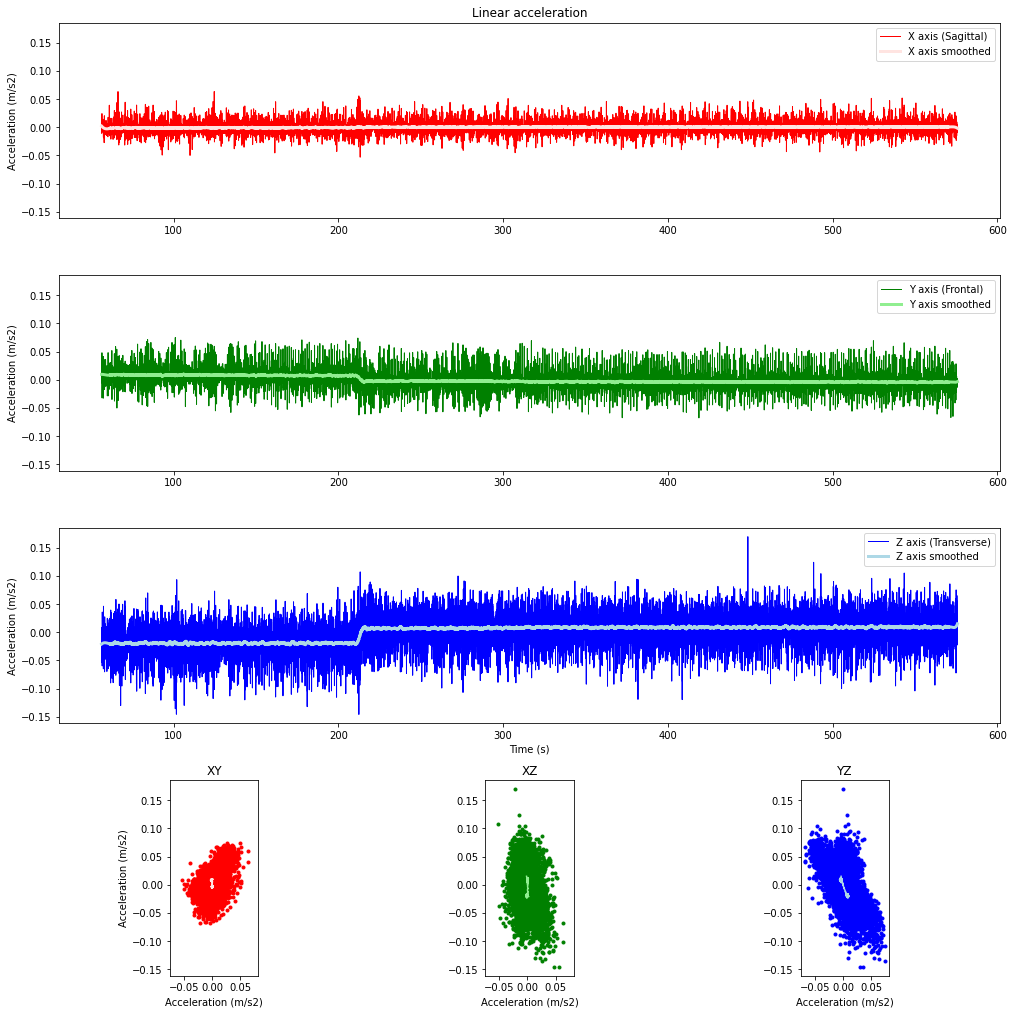

In [43]:
fig = plt.figure(figsize=(14,14))

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3)
ax1.plot(data_centered['ax'], lw=1, label='X axis (Sagittal)', color='red')
ax1.plot(data_sg['ax'], lw=3, label='X axis smoothed', color='mistyrose')
ax1.legend(loc='upper right')
#ax1.set_ylim(-0.15, 0.15)
plt.ylabel('Acceleration (m/s2)');
plt.title('Linear acceleration')

ax2 = plt.subplot2grid((4, 3), (1, 0), colspan=3, sharex=ax1, sharey=ax1)
ax2.plot(data_centered['ay'], lw=1, label='Y axis (Frontal)', color='green')
ax2.plot(data_sg['ay'], lw=3, label='Y axis smoothed', color='lightgreen')
ax2.legend(loc='upper right')
#ax2.set_ylim(-0.15, 0.15)
plt.ylabel('Acceleration (m/s2)');

ax3 = plt.subplot2grid((4, 3), (2, 0), colspan=3, sharex=ax1, sharey=ax1)
ax3.plot(data_centered['az'], lw=1, label='Z axis (Transverse)', color='blue')
ax3.plot(data_sg['az'], lw=3, label='Z axis smoothed', color='lightblue')
ax3.legend(loc='upper right')
#ax3.set_ylim(-0.15, 0.15)
plt.ylabel('Acceleration (m/s2)');
plt.xlabel('Time (s)');

ax4 = plt.subplot2grid((4, 3), (3, 0))
plt.plot(data_centered['ax'], data_centered['ay'], color='red', marker='.', linestyle='') #XY plane
plt.plot(data_sg['ax'], data_sg['ay'], color='mistyrose') #XY plane
plt.ylabel('Acceleration (m/s2)');
plt.xlabel('Acceleration (m/s2)');
plt.title('XY')
#ax4.set_xlim(-0.15, 0.15)
#ax4.set_ylim(-0.15, 0.15)
ax4.set_aspect('equal')

ax5 = plt.subplot2grid((4, 3), (3, 1), sharex=ax4, sharey=ax4)
plt.plot(data_centered['ax'], data_centered['az'], color='green', marker='.', linestyle='') #XZ plane
plt.plot(data_sg['ax'], data_sg['az'], color='lightgreen') #XZ plane
plt.xlabel('Acceleration (m/s2)');
plt.title('XZ')
#ax5.set_xlim(-0.15, 0.15)
#ax5.set_ylim(-0.15, 0.15)
ax5.set_aspect('equal')

ax6 = plt.subplot2grid((4, 3), (3, 2), sharex=ax4, sharey=ax4)
plt.plot(data_centered['ay'], data_centered['az'], color='blue', marker='.', linestyle='') #ZY plane
plt.plot(data_sg['ay'], data_sg['az'], color='lightblue') #YZ plane
plt.xlabel('Acceleration (m/s2)');
plt.title('YZ')
#ax6.set_xlim(-0.15, 0.15)
#ax6.set_ylim(-0.15, 0.15)
ax6.set_aspect('equal')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig("%s_linear_acceleration.pdf" % date, bbox_inches='tight', facecolor='white')

Making a plot of the transverse (horizontal) plane without axes. This can be nice to use for visualization.

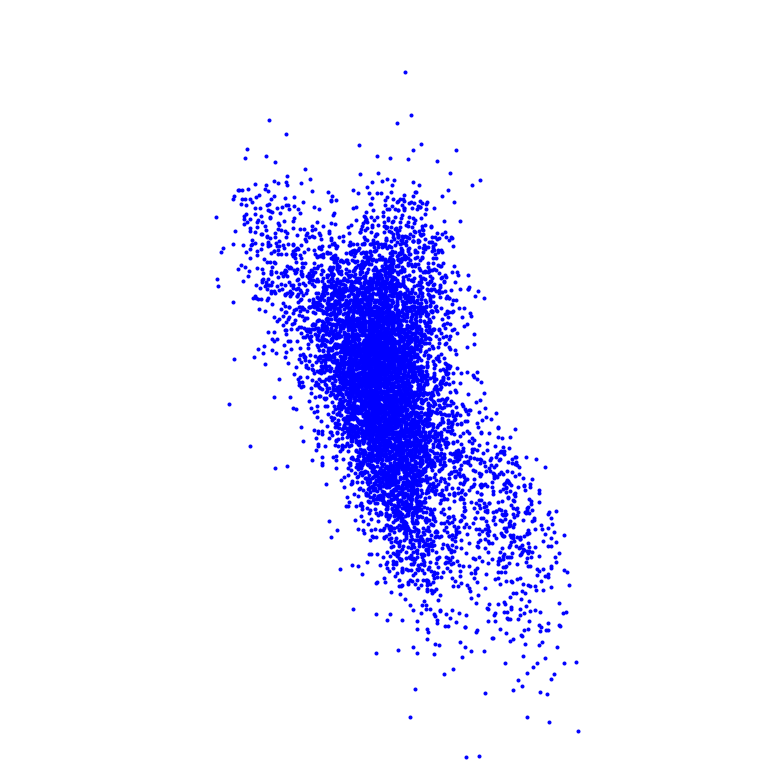

In [44]:
fig, ax = plt.subplots(figsize=(14,14))

plt.plot(data_centered['ay'], data_centered['az'], color='blue', marker='.', linestyle='') #ZY plane
#plt.plot(data_sg['ay'], data_sg['az'], color='lightblue') #YZ plane
plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.box(False)
ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.15, 0.15)
ax.set_aspect('equal')
plt.savefig("%s_transverse_acceleration.pdf" % date, bbox_inches='tight')

Calculating the spatial range as the area covered by the standard deviation of the data. This accounts for the center "blob" of the activity.

In [45]:
spatial_range = data_centered['ay'].std()*data_centered['az'].std()*1000
spatial_range

0.6981993289176014

I am unsure of the unit here. I guess it is in m/s2, but does that actually make any sense?

## Quantity of Motion

We will estimate the "quantity of motion" by looking at how much the acceleration values change over time. 

In [46]:
# Calculate difference between samples
displacement = (np.roll(data_centered, -1, axis=0) - data_centered)

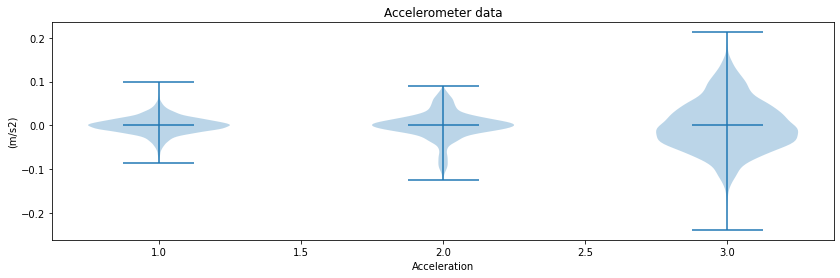

In [47]:
fig = plt.figure(figsize=(14,4))

plt.violinplot([displacement.ax, displacement.ay, displacement.az], showmeans=True)
plt.title('Accelerometer data')
#nocolumns = list(range(1,len(vels_group[46].columns)+1))
#ax.set_xticks(nocolumns)
#plt.xticklabels(["", "X", "", "Y", "", "Z"])
plt.xlabel('Acceleration');
plt.ylabel('(m/s2)');
fig.savefig("%s_acceleration_violinplots.pdf" % date, bbox_inches='tight',facecolor='white')

## Cumulative distance travelled

In [48]:
# Calculate the vector norm of the displacement
dispnorm = np.sqrt(
         displacement.ax ** 2 +
         displacement.ay ** 2 +
         displacement.az ** 2
    )

In [49]:
dispnorm.mean()

0.058264459161830554

In [50]:
dispnorm.median()

0.048681618707680625

In [51]:
dispnorm.std()

0.037002743706476326

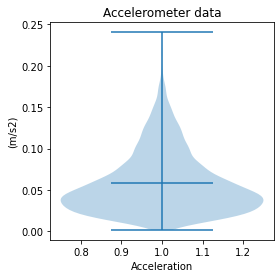

In [52]:
fig = plt.figure(figsize=(4,4))

plt.violinplot(dispnorm, showmeans=True)
plt.title('Accelerometer data')
#nocolumns = list(range(1,len(vels_group[46].columns)+1))
#ax.set_xticks(nocolumns)
#plt.xticklabels(["", "X", "", "Y", "", "Z"])
plt.xlabel('Acceleration');
plt.ylabel('(m/s2)');
fig.savefig("%s_acceleration_norm.pdf" % date, bbox_inches='tight',facecolor='white')

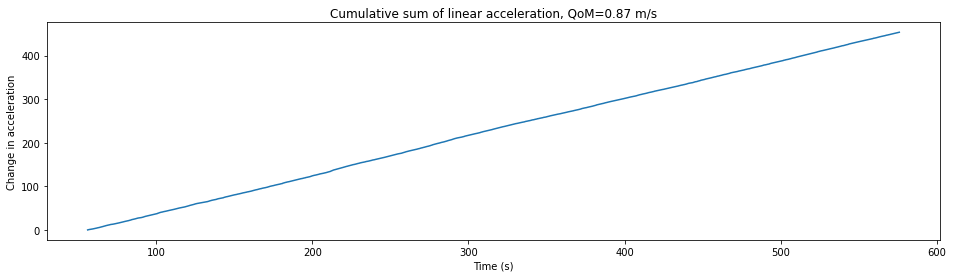

In [53]:
dispnormsum = dispnorm.cumsum() # Calculating the cumulative sum of all avalues
time_array = dispnormsum.index[1:]
duration = time_array[-1]-time_array[1]
qom = dispnormsum.iloc[-1]/duration # Finding the last value as Quantity of Motion

fig = plt.figure(figsize=(16,6))
ax = plt.subplot(1, 1, 1)
ax = dispnormsum.plot(figsize=(16,4)) #Indicate group number to plot
#ax.set_xlim(100, 110)
#ax.set_ylim(80, 110)
plt.xlabel('Time (s)');
plt.ylabel('Change in acceleration');
#plt.legend(loc='upper left')
plt.title('Cumulative sum of linear acceleration, QoM=%.2f m/s' %qom)
fig.savefig("%s_cumsum.pdf" % date, bbox_inches='tight',facecolor='white')

## Combined acceleration plot

In [54]:
window2

NameError: name 'window2' is not defined

In [55]:
order = 2 # The polynomial order of the filter
# The window size in seconds
window_s1 = 5
window_s2 = 60 

# The window size needs to be an odd number, so we need to check for that
if (window_s1 % 2) == 0:
   window1 = int(window_s1*sr)
else:
   window1 = int(window_s1*sr)+1

if (window_s % 2) == 0:
   window2 = int(window_s2*sr)+1
else:
   window2 = int(window_s2*sr)

dispnorm_sg1 = savgol_filter(dispnorm, window1, order)
dispnorm_sg2 = savgol_filter(dispnorm, window2, order)

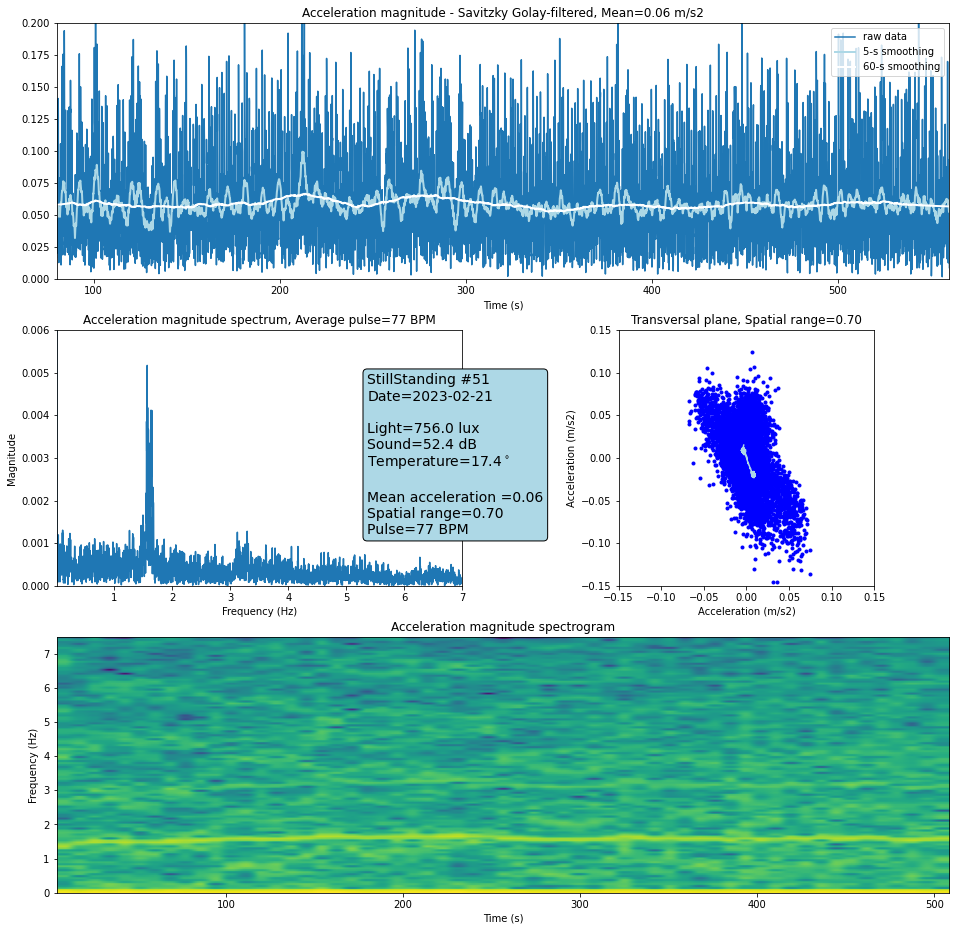

In [56]:
fig = plt.figure(figsize=(16,16))

ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)

ax1.plot(dispnorm, label='raw data')
ax1.plot(dispnorm.index, dispnorm_sg1, lw=2, label='5-s smoothing', color='lightblue')
ax1.plot(dispnorm.index, dispnorm_sg2, lw=2, label='60-s smoothing', color='white')
ax1.set_xlim(80, 560)
ax1.set_ylim(0, 0.2)
ax1.legend(loc='upper right')
plt.xlabel('Time (s)');
plt.title('Acceleration magnitude - Savitzky Golay-filtered, Mean=%.2f m/s2' % dispnorm.mean())

ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=1)
powerSpectrum, freqenciesFound, imageAxis = plt.magnitude_spectrum(dispnorm, Fs=sr)
ax2.set_xlim(0.001, 7)
ax2.set_ylim(0,0.006)
plt.title('Acceleration magnitude spectrum, Average pulse=%i BPM' %pulse)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

ax3 = plt.subplot2grid((3, 2), (1, 1), colspan=1)
plt.plot(data_centered['ay'], data_centered['az'], color='blue', marker='.', linestyle='') #ZY plane
plt.plot(data_sg['ay'], data_sg['az'], color='lightblue') #YZ plane
plt.xlabel('Acceleration (m/s2)');
plt.ylabel('Acceleration (m/s2)');
plt.title('Transversal plane, Spatial range=%.2f' %spatial_range)
ax3.set_xlim(-0.15, 0.15)
ax3.set_ylim(-0.15, 0.15)
ax3.set_aspect('equal')

# place a text box in upper left in axes coords
props = dict(boxstyle='round', facecolor='lightblue', alpha=1)
textstr = '\n'.join((
    r'StillStanding #%.i' % (stillstanding_no, ),
    r'Date=%s' % (date, ),
    r' ',
#    r'Environment:',
    r'Light=%.1f lux' % (light_level, ),
    r'Sound=%.1f dB' % (sound_level, ),
    r'Temperature=%.1f$^\circ$' % (temperature, ),
    r' ',
    r'Mean acceleration =%.2f' % (dispnorm.mean(), ),
    r'Spatial range=%.2f' % (spatial_range, ),
    r'Pulse=%i BPM' % (pulse, )    
))

ax3.text(0.25, 2.4, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax4 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(dispnorm, Fs=sr)
#ax4.set_ylim(0.001, 3)
plt.title('Acceleration magnitude spectrogram')

plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

fig.savefig("%s_combined_plot.pdf" % date, bbox_inches='tight',facecolor='white')

## Spherical video

We start by merging the two LRV files into one

In [57]:
# Create list of files
!printf "file '%s'\n" ../1-raw/*.LRV > mylist.txt

# Concatenate files
!ffmpeg -f concat -safe 0 -i mylist.txt -c copy spherical.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Need to check when I start the various things:

In [59]:
video_start_polar = '00:01:12'
video_start_clap = '00:01:19'
video_end_clap = '00:10:48'

In [60]:
!ffmpeg -i spherical.mp4 -ss 00:01:39 -t 00:08:00 -c copy spherical_trim.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [61]:
video_fn = 'spherical_trim.mp4'
video = mg.MgVideo(video_fn, skip=5)

Skipping frames: |████████████████████████████████████████| 100.0% Complete
Converting to mp4: |████████████████████████████████████████| 100.0% Complete


Rendering horizontal videogram: |████████████████████████████████████████| 100.0% Complete
Rendering vertical videogram: |████████████████████████████████████████| 100.0% Complete


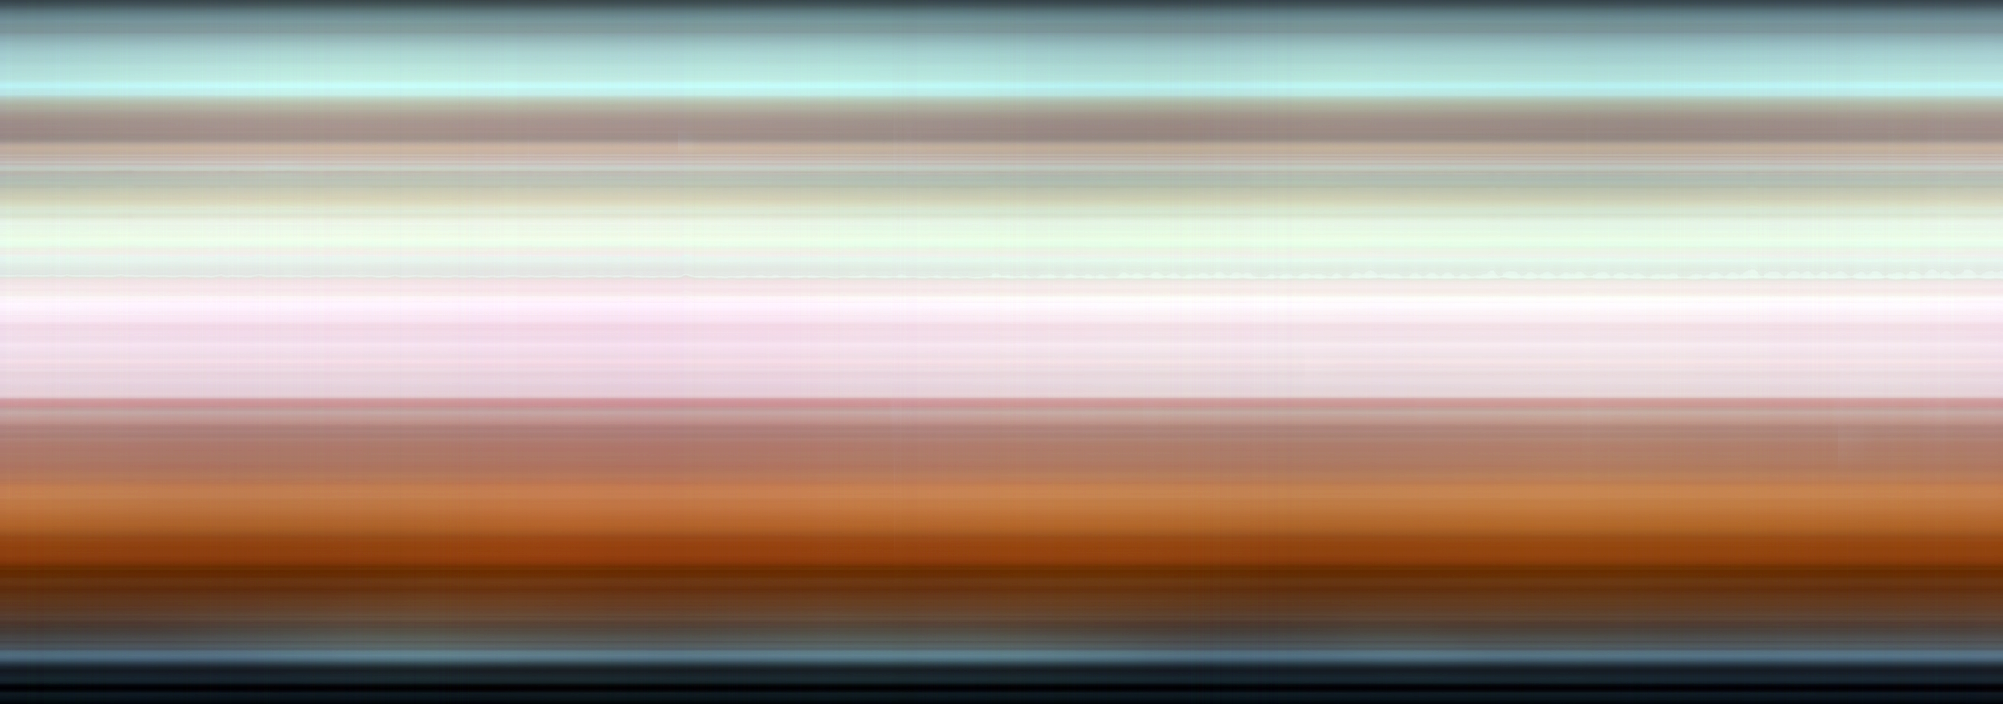

MgImage('/home/alexander/Dropbox (UiO)/Aktiv/Still Standing/02/2023-02-20/2-cooked/spherical_trim_skip_vgy.png')

In [62]:
videograms = video.videograms()
videograms[1].show(mode="notebook")

Converting to avi: |████████████████████████████████████████| 100.0% Complete
Rendering average image: |████████████████████████████████████████| 100.0% Complete


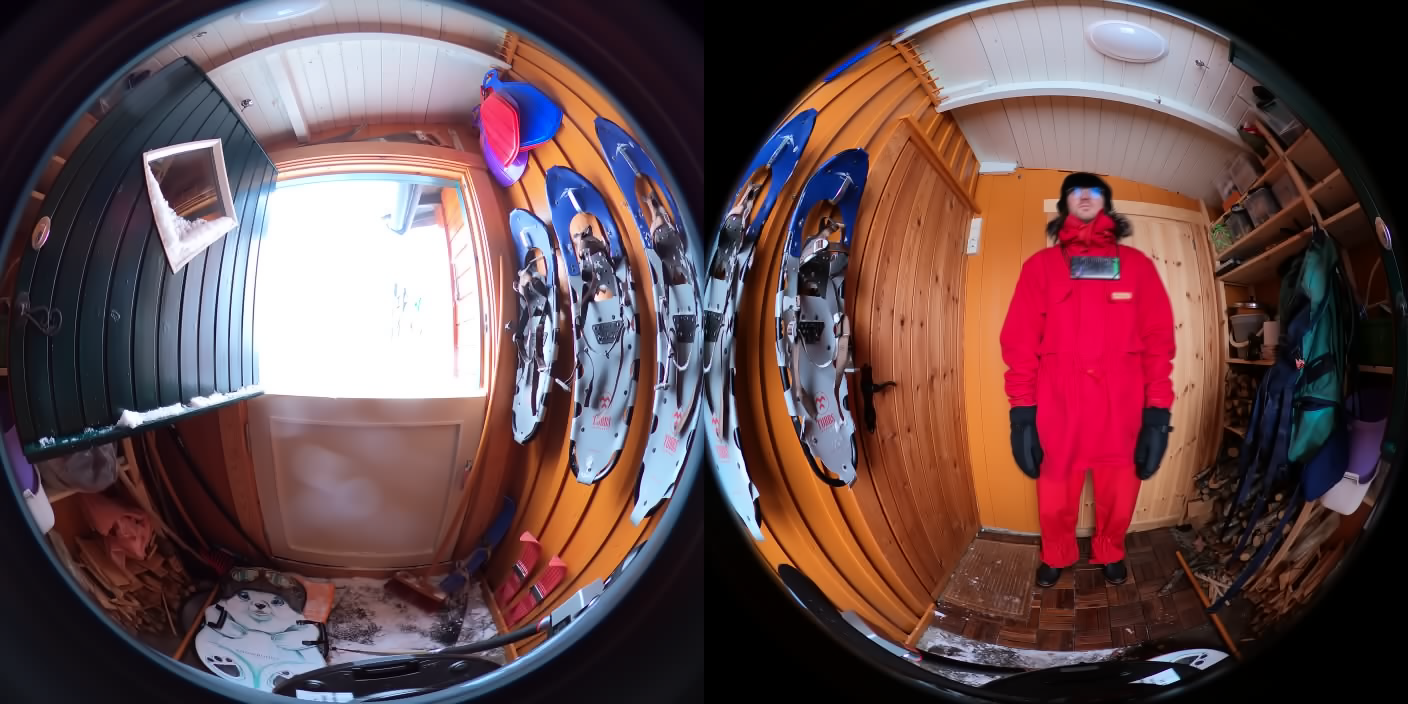

MgImage('/home/alexander/Dropbox (UiO)/Aktiv/Still Standing/02/2023-02-20/2-cooked/spherical_trim_skip_0_average.png')

In [63]:
video.average().show(mode="notebook")

### MG audio

In [64]:
video = mg.MgVideo('spherical_trim.mp4')

spherical_trim.mp4 is already in mp4 container.


MgFigure(figure_type='audio.waveform')

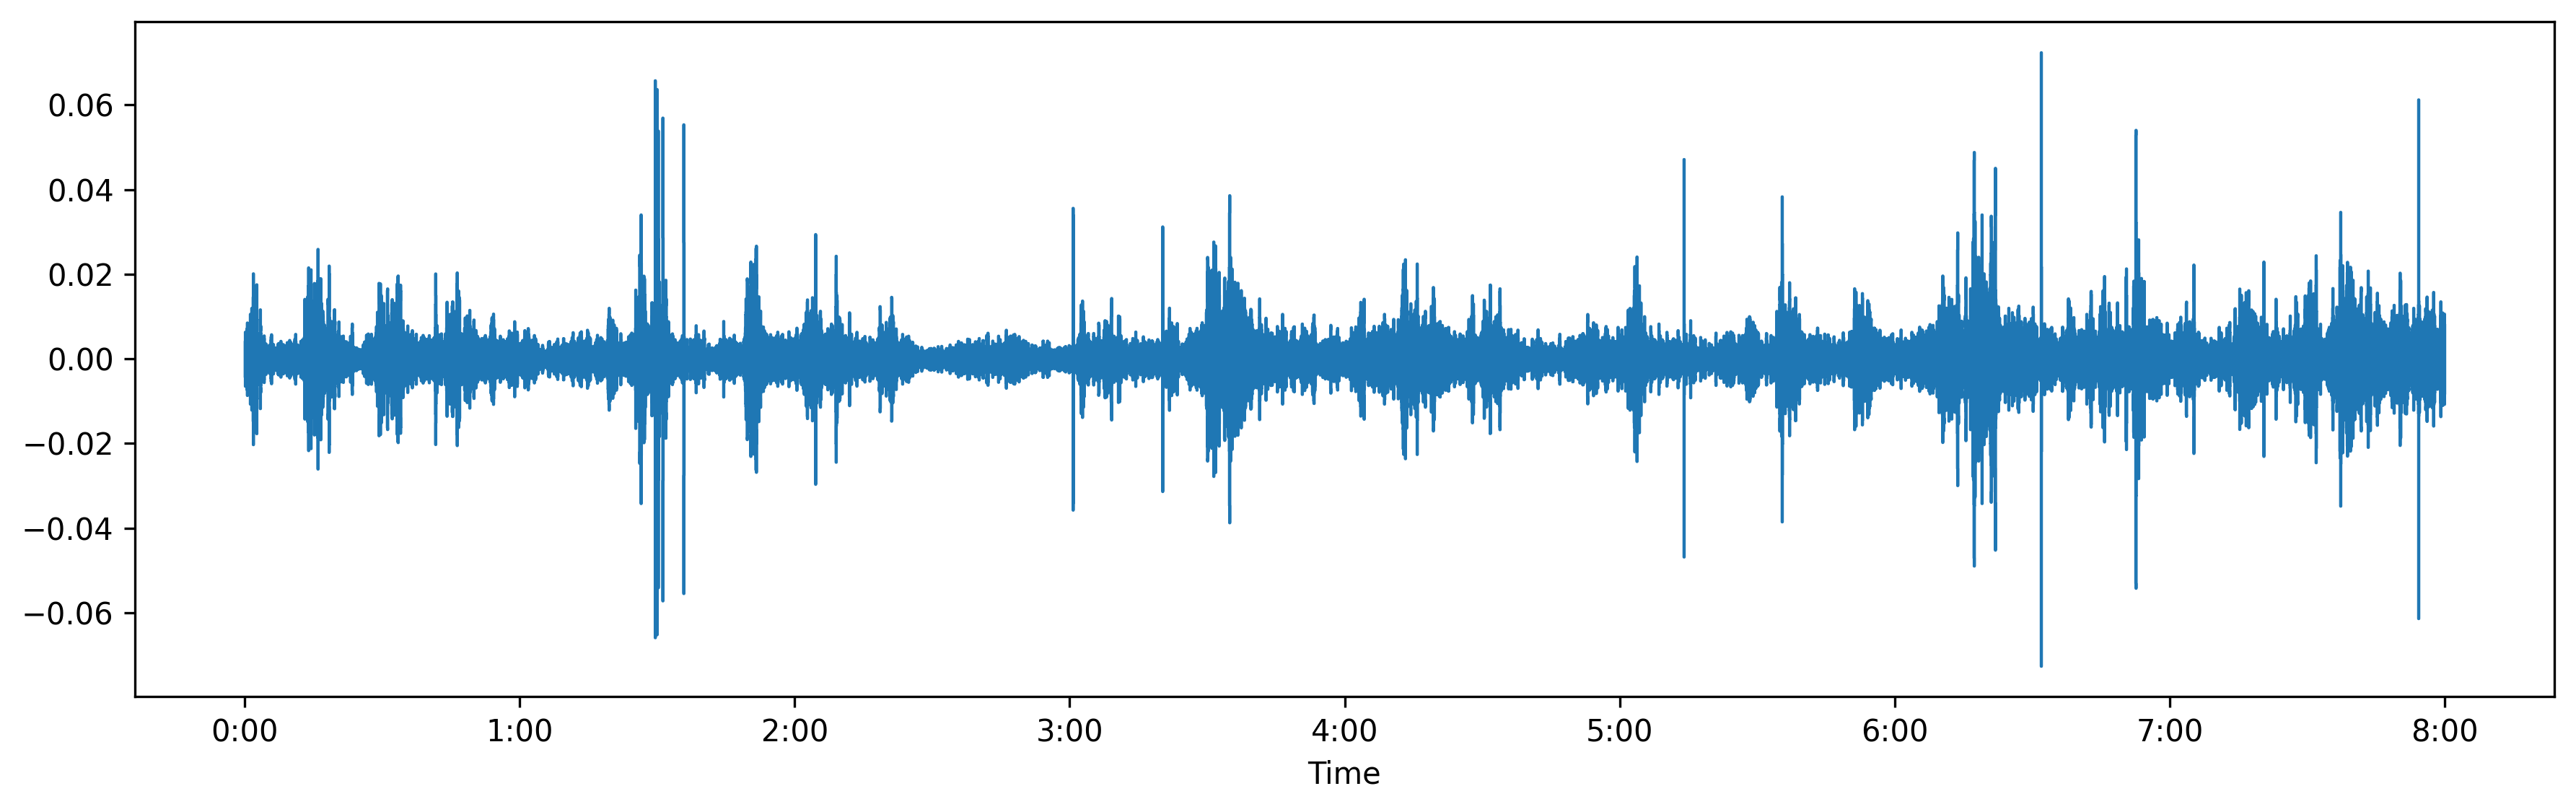

In [65]:
video.audio.waveform(title='')

MgFigure(figure_type='audio.spectrogram')

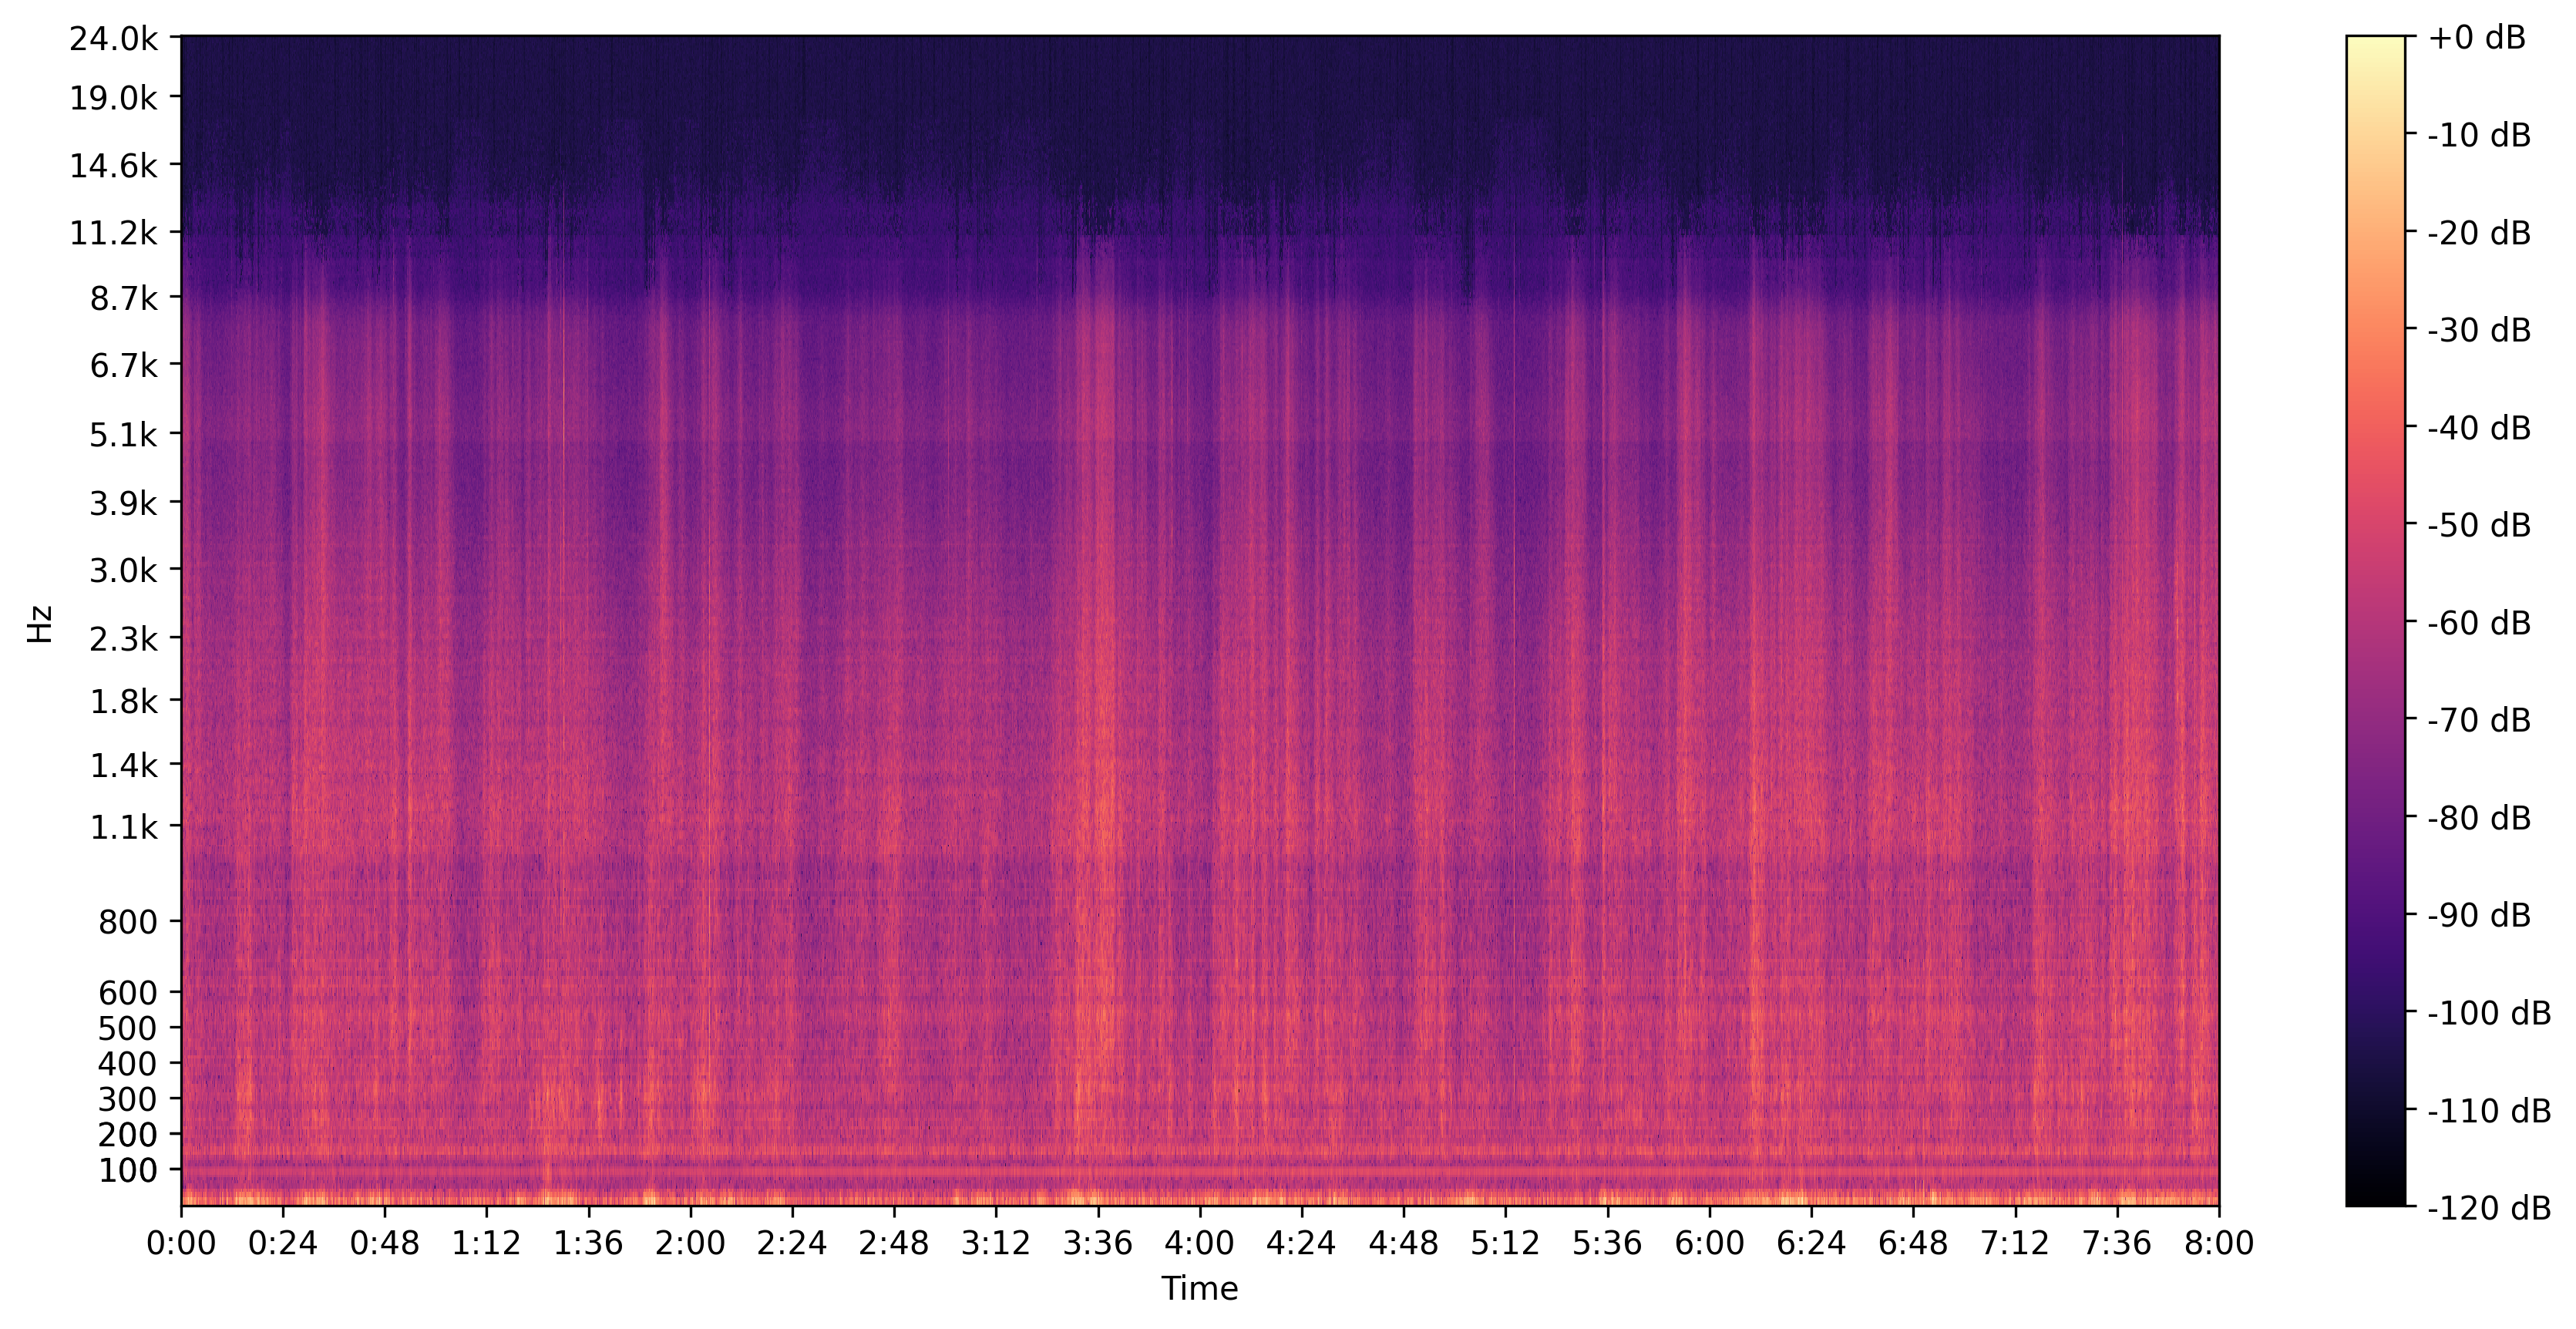

In [66]:
video.audio.spectrogram(title='')

In [67]:
#video.audio.descriptors(title='')

In [68]:
video = mg.MgVideo('spherical_trim_skip.mp4')

spherical_trim_skip.mp4 is already in mp4 container.


Rendering spectrogram SSM: |████████████████████████████████████████| 100.0% Complete


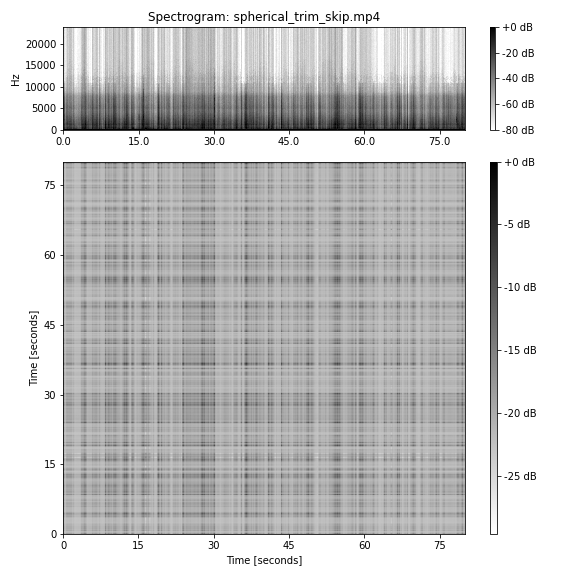

MgImage('/home/alexander/Dropbox (UiO)/Aktiv/Still Standing/02/2023-02-20/2-cooked/spherical_trim_skip_ssm.png')

In [69]:
spectrossm = video.ssm(features='spectrogram')
spectrossm.show(mode="notebook") # view both SSMs

## Video analysis

We start by investigating the 360 files. The recording is split across two files and each of these have two video layers internally.

In [70]:
# Create list of files
!printf "file '%s'\n" ../1-raw/*.360 > mylist.txt

# Concatenate files
!ffmpeg -f concat -safe 0 -i mylist.txt -map 0:0 -c copy track0.mp4 -map 0:5 -c copy track5.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Then we trim and crop the video

In [88]:
!ffplay -i track5.mp4 -ss 00:01:39 -t 00:08:00 -vf crop=1600:700:1150:450,transpose=2

ffplay version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2003-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [89]:
!ffmpeg -i track5.mp4 -ss 00:01:39 -t 00:08:00 -vf crop=1600:700:1150:450,transpose=2 track5_trim_crop_rot.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [90]:
video_fn = 'track5_trim_crop_rot.mp4'
video = mg.MgVideo(video_fn, skip=5)

Skipping frames: |████████████████████████████████████████| 100.0% Complete
Converting to mp4: |████████████████████████████████████████| 100.0% Complete


In [91]:
video.videograms()

Rendering horizontal videogram: |████████████████████████████████████████| 100.0% Complete
Rendering vertical videogram: |████████████████████████████████████████| 100.0% Complete


MgList('[MgImage('/home/alexander/Dropbox (UiO)/Aktiv/Still Standing/02/2023-02-20/2-cooked/track5_trim_crop_rot_skip_vgx.png'), MgImage('/home/alexander/Dropbox (UiO)/Aktiv/Still Standing/02/2023-02-20/2-cooked/track5_trim_crop_rot_skip_vgy.png')]')

In [92]:
video.average()

Converting to avi: |████████████████████████████████████████| 100.0% Complete
Rendering average image: |████████████████████████████████████████| 100.0% Complete


MgImage('/home/alexander/Dropbox (UiO)/Aktiv/Still Standing/02/2023-02-20/2-cooked/track5_trim_crop_rot_skip_0_average.png')

In [93]:
video.motion(inverted_motionvideo=True, inverted_motiongram=True).average()

Rendering motion-video, -grams, -plots, -data: |████████████████████████████████████████| 100.0% Complete
/home/alexander/Dropbox (UiO)/Aktiv/Still Standing/02/2023-02-20/2-cooked/track5_trim_crop_rot_skip_motion.mp4 is already in mp4 container.
Converting to avi: |████████████████████████████████████████| 100.0% Complete
Rendering average image: |████████████████████████████████████████| 100.0% Complete


MgImage('/home/alexander/Dropbox (UiO)/Aktiv/Still Standing/02/2023-02-20/2-cooked/track5_trim_crop_rot_skip_motion_average.png')

In [95]:
video.describe()

AttributeError: 'MgVideo' object has no attribute 'describe'

### Average subtraction

In [6]:
video = mg.MgVideo('spherical_trim_skip.avi')
# returns an MgVideo with background subtracted on the average of all video frames
subtraction = video.subtract()

Converting to mp4: |████████████████████████████████████████| 100.0% Complete
spherical_trim_skip.mp4 is already in mp4 container.
Converting to avi: |████████████████████████████████████████| 100.0% Complete
Rendering average image: |█████████████████████████████████████| 100.0% Complete
Subtracting background: |██████████████████████████████████████| 100.0% Complete
Converting to mp4: |████████████████████████████████████████| 100.0% Complete


In [7]:
subtraction.videograms()

Rendering horizontal videogram: |██████████████████████████████| 100.0% Complete
Rendering vertical videogram: |████████████████████████████████| 100.0% Complete


MgList('[MgImage('/home/alexander/Downloads/Still Standing/02/2023-02-05/2-cooked/spherical_trim_skip_subtracted_vgx.png'), MgImage('/home/alexander/Downloads/Still Standing/02/2023-02-05/2-cooked/spherical_trim_skip_subtracted_vgy.png')]')

In [8]:
subtraction.average()

Converting to avi: |████████████████████████████████████████| 100.0% Complete
Rendering average image: |█████████████████████████████████████| 100.0% Complete


MgImage('/home/alexander/Downloads/Still Standing/02/2023-02-05/2-cooked/spherical_trim_skip_subtracted_0_average.png')

### Motion video

In [75]:
video = mg.MgVideo('spherical_trim_skip.mp4')
motion = video.motion(inverted_motionvideo=True, inverted_motiongram=True, equalize_motiongram=True, thresh=0.3).average()

spherical_trim_skip.mp4 is already in mp4 container.
Rendering motion-video, -grams, -plots, -data: |███████████████| 100.0% Complete
/home/alexander/Dropbox (UiO)/Aktiv/Still Standing/02/2023-02-16/2-cooked/spherical_trim_skip_motion_1.mp4 is already in mp4 container.
Converting to avi: |████████████████████████████████████████| 100.0% Complete
Rendering average image: |█████████████████████████████████████| 100.0% Complete


In [28]:
video = mg.MgVideo('spherical_trim_skip.mp4')
motion = video.motion(thresh=0.5).average()

Converting to mp4: |████████████████████████████████████████| 100.0% Complete
Rendering motion-video, -grams, -plots, -data: |███████████████| 100.0% Complete
/home/alexander/Downloads/Still Standing/02/2023-02-05/2-cooked/spherical_trim_skip_motion_0.mp4 is already in mp4 container.
Converting to avi: |████████████████████████████████████████| 100.0% Complete
Rendering average image: |█████████████████████████████████████| 100.0% Complete


In [65]:
video = mg.MgVideo('spherical_trim.mp4')
motion = video.motion(inverted_motionvideo=False, inverted_motiongram=False, equalize_motiongram=False, thresh=0.).average()

spherical_trim.mp4 is already in mp4 container.
Rendering motion-video, -grams, -plots, -data: |███████████████| 100.0% Complete
/home/alexander/Dropbox (UiO)/Aktiv/Still Standing/02/2023-02-11/2-cooked/spherical_trim_motion.mp4 is already in mp4 container.
Converting to avi: |████████████████████████████████████████| 100.0% Complete
Rendering average image: |████████████████████████████████████████| 100.0% Complete


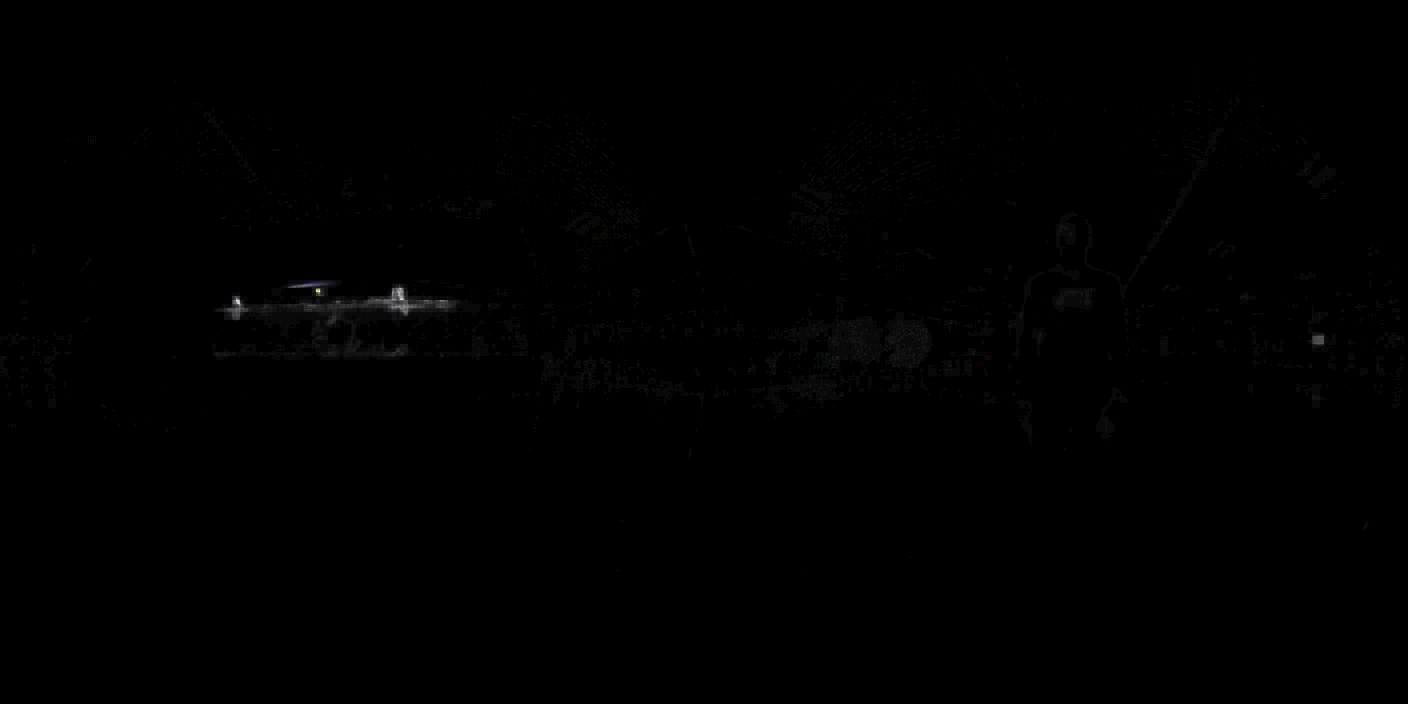

MgImage('/home/alexander/Downloads/Still Standing/02/2023-02-05/2-cooked/spherical_trim2_motion_average.png')

In [12]:
motion.show(mode="notebook")

In [13]:
video = mg.MgVideo('spherical_trim.mp4')

spherical_trim.mp4 is already in mp4 container.


Rendering motion-grams: |██████████████████████████████████████| 100.0% Complete
Rendering self-similarity matrices: |██████████████████████████| 100.0% Complete


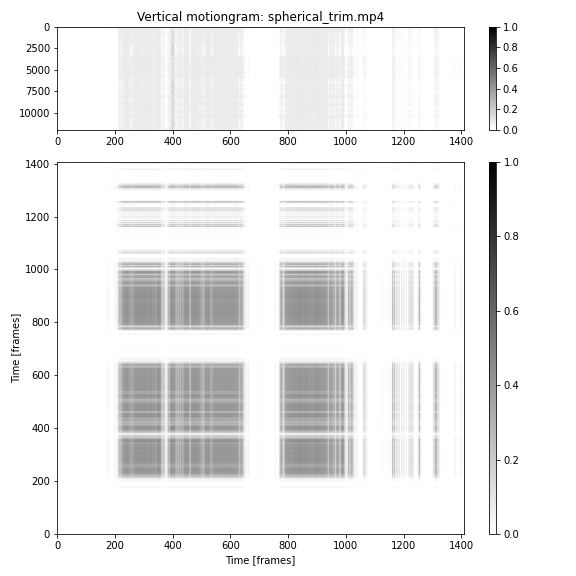

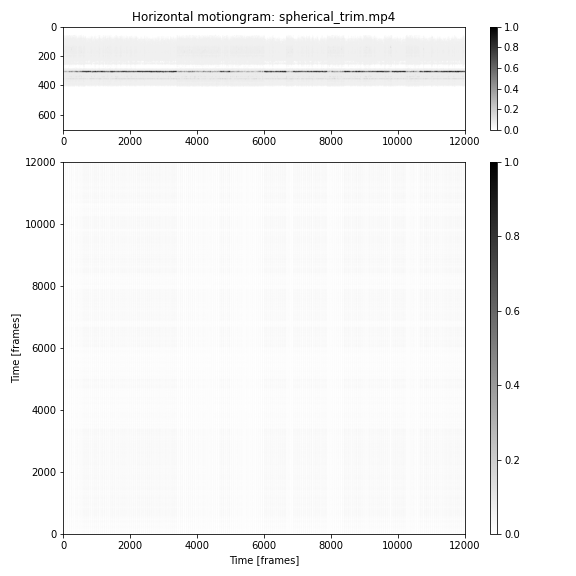

In [14]:
motionssm = video.ssm(features='motiongrams') # returns an MgList with the motion SSMs as MgImages
motionssm.show(mode="notebook") # view chromagram SSM

## Audio analysis - librosa

In [96]:
!ffmpeg -i spherical_trim.mp4 -c copy spherical_trim.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [97]:
y, sr = librosa.load('spherical_trim.wav', offset=100, duration=500)

ValueError: Input signal length=0 is too small to resample from 48000->22050

In [ ]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(16,6))

librosa.display.waveshow(y, sr=sr)

ax.set(title='Audio waveform')
ax.legend()

fig.savefig("audio_waveform.pdf", bbox_inches='tight',facecolor='white', dpi=150)

In [ ]:
y_harm, y_perc = librosa.effects.hpss(y, margin=3)

In [ ]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(16,6))

#librosa.display.waveplot(y, sr=sr, ax=ax[0])

#ax[0].set(title='Envelope view, mono')
#ax[0].label_outer()

librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, label='Percussive')

ax.set(title='Audio waveforms of harmonic and percussive components')
ax.legend()

fig.savefig("audio_waveform_harmonic_percussive.pdf", bbox_inches='tight',facecolor='white', dpi=150)

In [ ]:
D = librosa.stft(y)

In [ ]:
# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(D))

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=rp), y_axis='log', x_axis='time')
plt.title('Spectrogram of audio recording')

plt.tight_layout()
plt.savefig("audio_spectrogram.pdf", bbox_inches='tight',facecolor='white', dpi=150)

In [ ]:
D_harmonic, D_percussive = librosa.decompose.hpss(D)

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=rp), y_axis='log')
plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(D_harmonic, ref=rp), y_axis='log')
plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(D_percussive, ref=rp), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive spectrogram')
plt.tight_layout()

## Cleaning up

Convert all PDF files to jpg

In [97]:
!for i in *.pdf; do name=`echo $i | cut -d'.' -f1`; pdftoppm "$i" "$name" -jpeg -rx 150 -ry 150 -singlefile; done

In [26]:
!pdfcrop  video-plots.pdf

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `video-plots-crop.pdf'.


In [4]:
!pdftoppm video-plots-crop.pdf combined-plots-crop -jpeg -rx 150 -ry 150 -singlefile

I/O Error: Couldn't open file 'video-plots-crop.pdf': No such file or directory.
